# MAB experiments

### Libraries

In [1]:
# Imports and defaults
import itertools
import joblib
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
import scipy.optimize as spo
from scipy import optimize
import time
from collections import defaultdict
import random
from tqdm import tqdm

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)
print("%d joblib cores" % joblib.cpu_count())

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

np.random.seed(0)
random.seed(0)

python 3.9.13
matplotlib 3.5.2
8 joblib cores


### Useful functions

In [2]:
def factorized_upper_bound(p, K, mu_0, v_0, v, n):
    
    # compute_phi
    coeffs = v/n + p * v_0
    
    # compute numerator
    numerator_matrix = np.outer((v_0**2) * p, coeffs)
    numerator_matrix = numerator_matrix + numerator_matrix.T
    
    denominator_matrix = np.outer(v * v_0, coeffs)
    denominator_matrix = denominator_matrix + denominator_matrix.T
    
    phi_ij = numerator_matrix / denominator_matrix
    
    term_1 = np.exp(-(mu_0 - mu_0[:,np.newaxis])**2 /(2 * (v_0 + v_0[:,np.newaxis])))
    main_matrix = term_1 / np.sqrt(1 + n * phi_ij)
    
    return np.sum(main_matrix) - np.trace(main_matrix)

def adjust_multi(w):
  w_new = np.asarray(w).astype('float64')
  return w_new / np.sum(w_new)

def compute_w_opt_one(cons, bounds, K, mu_0, v_0, v, n, alpha) :
    
    p_start = np.random.random(K) 
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])
    result = optimize.minimize(factorized_upper_bound, p_start, args=(K, mu_0, v_0, v, n), bounds=bounds, constraints=cons)
    w_opt = result.x

    w_tilde_tmp = mu_0 * v_0 / np.sum(v_0) 
    w_tilde = w_tilde_tmp / np.linalg.norm(w_tilde_tmp)

    tmp_w_mix = alpha * w_opt + (1 - alpha) * w_tilde 
    w = tmp_w_mix / np.sum(tmp_w_mix) 
    return w

def compute_w_opt(K, mu_0, v_0, v, n, alpha, num_MC=5000) :
   
   cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
   bounds = tuple([(0, 1) for _ in range(K)])
   
   w_opt_matrix = Parallel(n_jobs=-1)(delayed(compute_w_opt_one)(cons, bounds, K, mu_0, v_0, v, n, alpha) for ex in tqdm(range(num_MC)))
   w_opt_final = w_opt_matrix[np.argmin([factorized_upper_bound(omega, K, mu_0, v_0, v, n) for omega in w_opt_matrix])]
   return adjust_multi(w_opt_final)

def objective_function_G_opt(omega, v_0, v, n) :
   information_matrix = np.diag((1/v_0) + (omega * n/v))  # inverse of posterior covariance matrix
   s, logdet = np.linalg.slogdet(information_matrix)
   return - s * logdet

def compute_w_optimal_design_one(cons, bounds,  v_0, v, K, n) :
    
    p_start = np.random.random(K)  
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])
    result = optimize.minimize(objective_function_G_opt, p_start, args=(v_0, v, n), bounds=bounds, constraints=cons)
    return result.x

def compute_w_optimal_design(v_0, v, K, n, num_MC=100) :

   cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
   bounds = tuple([(0, 1) for _ in range(K)])
   
   w_opt_matrix = Parallel(n_jobs=-1)(delayed(compute_w_optimal_design_one)(cons, bounds,  v_0, v, K, n) for ex in tqdm(range(num_MC)))
   w_opt_final = w_opt_matrix[np.argmin([objective_function_G_opt(omega, v_0, v, n) for omega in w_opt_matrix])]
   return adjust_multi(w_opt_final)


### Bandit Environment 

In [3]:
# Bandit environments
class BanditEnvironment(object):
  """Contextual bandit with K arms."""

  def __init__(self, K, theta, sigma):
    self.K = K  # number of arms
    self.theta = np.copy(theta)  # list of reward means
    self.sigma = sigma  # reward noise
    self.best_arm = np.argmax(self.theta)
    self.randomize()

  def randomize(self):
    self.rt = self.theta + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def print(self):
    return "Bandit Environment: %d arms" % (self.K)


def evaluate_one(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return 1 * (J_n != env.best_arm)


def evaluate(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

In [4]:
def evaluate_one_sr(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return env.theta[env.best_arm] - env.theta[J_n]


def evaluate_sr(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one_sr)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

In [5]:
def evaluate_one_epsilon(Alg, env, n, epsilon):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
    
  if env.theta[env.best_arm] - env.theta[J_n] < epsilon:
    return 0
  else: 
    return 1


def evaluate_epsilon(Alg, env, n, epsilon, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one_epsilon)(Alg, env[ex], n, epsilon) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

### Warm-up Algorithms

In [6]:
# Thompson sampling algorithms that are only used to estimate the best allocations n_i
class TS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def get_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu_hat = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
      self.mu[i] = mu_hat + np.sqrt(sigma_hat_square) * np.random.randn()
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "TS"

In [7]:
class T3C:
  """
  Based on "Top Two Sampling Revisited, (Jourdan et al., 2022)
  Particularly, we choose the TS-TC procedure, which also corresponds to the T3C algorithm (Shang et al, 2019).
  We do not use TTTS (ie. TS-TC) because as the posterior becomes concentrated, it requires to much sampling and becomes intractable.
  """
  def __init__(self, env, n):
    
    self.t = 0
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.beta = 1/2 # hyperparameter, we choose 1/2 based on empirical arguments of (Jourdan et al, 2022)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    self.t+=1

  def compute_W(self, i, j) :
    if self.mu_hat[j] > self.mu_hat[i] :
      return 0
    return ((self.mu_hat[i] - self.mu_hat[j])**2) / ( 2 * (self.sigma**2) * ( (1/self.n_i[i]) + (1/self.n_i[j]) ) )
    
  def get_arm(self):
    # compute posterior means
    if self.t < self.K :
      return self.t
    
    else :
      self.mu_hat = np.zeros(self.K)
      self.Sigma_hat = np.eye(self.K)
      for i in range(self.K):
        # arm parameter posterior
        sigma_hat_helper_i = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
        self.Sigma_hat[i, i] = 1/sigma_hat_helper_i  
        self.mu_hat[i] = self.Sigma_hat[i, i] * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))

      # TS leader
      leader = np.argmax(self.mu_hat) 

      # TC challenger
      arm_candidate = np.argmin([self.compute_W(leader, i) for i in range(self.K)])
      if arm_candidate != leader :
        challenger = arm_candidate
      else :
        list_helper = [self.compute_W(leader, i) for i in range(self.K)]
        challenger = list_helper.index(sorted(list_helper)[1])

      u = np.random.uniform(0, 1)
      return leader if (u < self.beta) else challenger # Choose challenger wp beta
    

  """ In case one need to use T3C as a full BAI algorithm (ie not only as a warm-up) """

  def explore(self, n) :
    for t in range(self.n) :
      self.env.randomize()
      arm_t = self.get_arm()
      self.update(arm_t, self.env.reward(arm_t))
  
  def get_best_arm(self):
    # compute posterior means at the end of the final round
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return np.argmax(self.mu)
  
  @staticmethod
  def print():
    return "T3C"

In [8]:
class TSTCI:
  """
  Based on "Top Two Sampling Revisited, (Jourdan et al., 2022)
  Particularly, we choose the TS-TC procedure, which also corresponds to the T3C algorithm (Shang et al, 2019).
  We do not use TTTS (ie. TS-TC) because as the posterior becomes concentrated, it requires to much sampling and becomes intractable.
  """
  def __init__(self, env, n):
    self.t = 0
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.beta = 1/2 # hyperparameter, we choose 1/2 based on empirical arguments of (Jourdan et al, 2022)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    self.t+=1

  
  def compute_W(self, i, j) :
    if self.mu_hat[j] > self.mu_hat[i] :
      return 0
    return ((self.mu_hat[i] - self.mu_hat[j])**2) / ( 2 * (self.sigma**2) * ( (1/self.n_i[i]) + (1/self.n_i[j]) ) )
    
  def get_arm(self):
    # compute posterior means
    if self.t < self.K :
      return self.t
    
    else :
      self.mu_hat = np.zeros(self.K)
      self.Sigma_hat = np.eye(self.K)
      for i in range(self.K):
        # arm parameter posterior
        sigma_hat_helper_i = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
        self.Sigma_hat[i, i] = 1/sigma_hat_helper_i  
        self.mu_hat[i] = self.Sigma_hat[i, i] * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))

      # TS leader
      leader = np.argmax(self.mu_hat) 

      # TC challenger
      arm_candidate = np.argmin([self.compute_W(leader, i) for i in range(self.K)])
      if arm_candidate != leader :
        challenger = arm_candidate
      else :
        list_helper = [self.compute_W(leader, i) + np.log(self.n_i[i]) for i in range(self.K)]
        challenger = list_helper.index(sorted(list_helper)[1])

      u = np.random.uniform(0, 1)
      return leader if (u < self.beta) else challenger # Choose challenger wp beta
    

  """ In case one need to use TSTCI as a full BAI algorithm (ie not only as a warm-up) """

  def explore(self, n) :
    for t in range(self.n) :
      self.env.randomize()
      arm_t = self.get_arm()
      self.update(arm_t, self.env.reward(arm_t))
  
  def get_best_arm(self):
    # compute posterior means at the end of the final round
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm
  
  @staticmethod
  def print():
    return "TSTCI"

### BAI Algorithms 

In [9]:
class PI_BAI_Uni:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(n//self.K):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-Uni"

In [10]:
class PI_BAI_Opt:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise
    self.w_opt = self.env.w_opt
    self.n_samples = np.random.multinomial(self.n, self.w_opt)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-Opt"

In [11]:
class PI_BAI_G_Opt:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise
    self.w_optimal_design = self.env.w_optimal_design

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(int(self.w_optimal_design[i] * n)):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-G-Opt"

In [12]:
# Bayesian Successive Elimination
class BayesElim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = env.sigma  # reward noise

    self.S_r = np.arange(self.K)
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        self.clear_history()
        for i in self.S_r:
            for t in range(int(n//(self.R * len(self.S_r)))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))
            mu = self.compute_posterior_mean()
            
        self.S_r = np.argsort(mu)[::-1][:int(np.ceil(len(self.S_r)//2))]
        #print(self.S_r)
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
          
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "BayesElim"

In [13]:
# Successive Rejects
class SR:
  """
  Based on (Audibert et al, 2010)
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.n0 = 0
    self.log_bar = 0.5 + np.sum([1/i for i in range(2, self.K + 1)])
    self.S_r = np.arange(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

    self.nb_pulls_SR = np.zeros(self.K + 1)
    self.nb_pulls_SR[0] = self.n0
    for i in range(1, self.K+1) :
       self.nb_pulls_SR[i] = np.ceil( (self.n - self.K) / ( self.log_bar * (self.K + 1 - i) ) )

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1

  def explore(self, n):
    # explore actions
    for r in range(self.K-1):
      #self.clear_history()    SR does not clear its history
      for i in self.S_r :
        for t in range( int(self.nb_pulls_SR[r+1] - self.nb_pulls_SR[r]) ) :
          self.env.randomize()
          self.update(i, self.env.reward(i))
      mu = self.B / self.n_i #self.compute_empirical_mean()
      self.S_r = np.argsort(mu)[::-1][:-(r+1)]

  def get_best_arm(self):
    return self.S_r[0] # there is only one arm left in S_r at this stage.

  @staticmethod
  def print():
    return "SR"

In [14]:
# Frequentist Successive Elimination
class SH:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n = n  # budget
    self.S_r = np.arange(self.K)
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        self.clear_history()
        for i in self.S_r:
            for t in range(int(n//(self.R * len(self.S_r)))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))
            mu = self.compute_posterior_mean()
        self.S_r = np.argsort(mu)[::-1][:int(np.ceil(len(self.S_r)//2))]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      mu[i] = self.B[i] / self.n_i[i]
    return mu
          
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "SH"

In [15]:
class PI_BAI_TS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    ts_alg = TS(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = ts_alg.get_arm()
        ts_alg.update(arm, env.reward(arm))
    self.w_ts = ts_alg.n_i / self.n_w        
    self.n_samples = np.random.multinomial(self.n, self.w_ts)

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-TS"

In [16]:
class PI_BAI_T3C:
  """
  This is a variant of TTTS and corresponds to TS-TC of (Jourdan et al, 2023). It also corresponds to (Shang et al, 2020). Note that the latter offers a closed-form 
  formula for the transportation cost for Gaussian distributions.
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    T3C_alg = T3C(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = T3C_alg.get_arm()
        T3C_alg.update(arm, env.reward(arm))
    self.w_ttts = T3C_alg.n_i / self.n_w  
    self.n_samples = np.random.multinomial(self.n, self.w_ttts) 

    # sufficient statistics : NO DISCARD
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-T3C"

In [17]:
class PI_BAI_TSTCI:
  """
  This is a variant of TTTS and corresponds to TS-TCI of (Jourdan et al, 2023). 
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
            
    TSTCI_alg = T3C(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = TSTCI_alg.get_arm()
        TSTCI_alg.update(arm, env.reward(arm))
    self.w_tstci = TSTCI_alg.n_i / self.n_w  
    self.n_samples = np.random.multinomial(self.n, self.w_tstci) 

    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
    
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      self.mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "PI-BAI-TSTCI"

### BAI with elimination

In [18]:
class PI_BAI_Uni_Elim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n # budget 
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.w_uni = np.ones(self.K) / self.K
    
    self.S_r = np.arange(self.K)
    self.S_r_bar = np.array([])
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)

    for i in self.S_r_bar:
        self.w_uni[i] = 0
    
    if np.sum(self.w_uni)==0:
        for i in self.S_r:
            self.w_uni[i] = 1
            
    self.w_uni = self.w_uni / np.sum(self.w_uni)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        
        self.clear_history() # draft observations at each round

        for i in self.S_r: 
            for t in range(int(self.w_uni[i]*(n/self.R))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))

            mu = self.compute_posterior_mean()

        sorted_arms = np.argsort(mu)[::-1]   
        self.S_r = sorted_arms[:int(np.ceil(len(self.S_r)//2))]
        self.S_r_bar = sorted_arms[int(np.ceil(len(self.S_r)//2)):]
        
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
          
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "PI-BAI-Uni(+Elim)"

In [19]:
class PI_BAI_Opt_Elim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n # budget 
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.w_opt = self.env.w_opt
    
    self.S_r = np.arange(self.K)
    self.S_r_bar = np.array([])
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)

    for i in self.S_r_bar:
        self.w_opt[i] = 0
    
    if np.sum(self.w_opt)==0:
        for i in self.S_r:
            self.w_opt[i] = 1
            
    self.w_opt = self.w_opt / np.sum(self.w_opt)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        
        self.clear_history() # draft observations at each round

        for i in self.S_r: 
            for t in range(int(self.w_opt[i]*(n/self.R))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))

            mu = self.compute_posterior_mean()

        sorted_arms = np.argsort(mu)[::-1]   
        self.S_r = sorted_arms[:int(np.ceil(len(self.S_r)//2))]
        self.S_r_bar = sorted_arms[int(np.ceil(len(self.S_r)//2)):]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
          
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "PI-BAI-Opt(+Elim)"

In [20]:
class PI_BAI_G_Opt_Elim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n # budget 
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise
    self.w_optimal_design = self.env.w_optimal_design
    
    self.S_r = np.arange(self.K)
    self.S_r_bar = np.array([])
    self.R = np.log2(self.K)
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)

    for i in self.S_r_bar:
        self.w_optimal_design[i] = 0
    
    if np.sum(self.w_optimal_design)==0:
        for i in self.S_r:
            self.w_optimal_design[i] = 1
            
    self.w_optimal_design = self.w_optimal_design / np.sum(self.w_optimal_design)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        
        self.clear_history() # draft observations at each round

        for i in self.S_r: 
            for t in range(int(self.w_optimal_design[i]*(n/self.R))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))

            mu = self.compute_posterior_mean()

        sorted_arms = np.argsort(mu)[::-1]   
        self.S_r = sorted_arms[:int(np.ceil(len(self.S_r)//2))]
        self.S_r_bar = sorted_arms[int(np.ceil(len(self.S_r)//2)):]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "PI-BAI-G-Opt(+Elim)"

In [21]:
class PI_BAI_TS_Elim:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.n_w = self.env.n_w # TS exploration budget
    self.n = n - self.n_w # budget 
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.sigma_0 = np.copy(env.sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.sigma = self.env.sigma  # reward noise

    self.S_r = np.arange(self.K)
    self.S_r_bar = np.array([])
    self.R = np.log2(self.K)
    
    ts_alg = TS(self.env, self.n_w)
    for _ in range(self.n_w):
        self.env.randomize()
        arm = ts_alg.get_arm()
        ts_alg.update(arm, env.reward(arm))
    self.w_ts = ts_alg.n_i / self.n_w        
    
    # sufficient statistics
    self.B = np.zeros(self.K) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B[arm] += r
    self.n_i[arm] += 1
    
  def clear_history(self):
    # update sufficient statistics
    self.B = np.zeros(self.K)
    self.n_i = np.zeros(self.K)
    for i in self.S_r_bar:
        self.w_ts[i] = 0
    if np.sum(self.w_ts)==0:
        for i in self.S_r:
            self.w_ts[i] = 1
    self.w_ts = self.w_ts / np.sum(self.w_ts)
    
  def explore(self, n):
    # explore actions
    for r in range(int(np.floor(self.R))):
        #print([int(self.w_ts[i]*(n/self.R)) for i in self.S_r])
        self.clear_history()
        for i in self.S_r:
            for t in range(int(self.w_ts[i]*(n/self.R))):
                self.env.randomize()
                # update statistics
                self.update(i, self.env.reward(i))
            mu = self.compute_posterior_mean()
        sorted_arms = np.argsort(mu)[::-1]   
        self.S_r = sorted_arms[:int(np.ceil(len(self.S_r)//2))]
        self.S_r_bar = sorted_arms[int(np.ceil(len(self.S_r)//2)):]
                
  def compute_posterior_mean(self):
    # compute posterior means
    mu = - np.inf * np.ones(self.K) 
    for i in self.S_r:
      # arm parameter posterior
      sigma_hat_helper = 1/(self.sigma_0[i]**2) + self.n_i[i]/(self.sigma**2)
      sigma_hat_square = 1/sigma_hat_helper  
      mu[i] = sigma_hat_square * (self.mu_0[i]/(self.sigma_0[i]**2) + self.B[i]/(self.sigma**2))
    return mu
          
    
  def get_best_arm(self):
    # compute posterior means
    return self.S_r[0]

  @staticmethod
  def print():
    return "PI-BAI-TS(+Elim)"

### Experiments: Varying the budget n

100%|██████████| 100/100 [00:00<00:00, 1019.17it/s]


[0.   0.   0.   0.   0.   0.04 0.15 0.22 0.28 0.32]
Running experiments with n = 20


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.   0.   0.08 0.13 0.17 0.19 0.21 0.22]
Running experiments with n = 60


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.   0.05 0.1  0.14 0.16 0.17 0.18 0.19]
Running experiments with n = 100


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.01 0.08 0.11 0.14 0.15 0.16 0.17 0.18]
Running experiments with n = 140


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.03 0.09 0.12 0.13 0.15 0.16 0.16 0.17]
Running experiments with n = 180


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.05 0.09 0.12 0.13 0.14 0.15 0.15 0.16]
Running experiments with n = 220


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.06 0.1  0.12 0.13 0.14 0.15 0.15 0.15]
Running experiments with n = 260


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.07 0.1  0.12 0.13 0.14 0.14 0.15 0.15]
Running experiments with n = 300


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

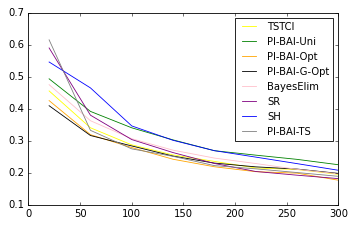

In [18]:
np.random.seed(0)
random.seed(0)

sigma = 1 # observation noise
num_runs = 10000 # number of experiments

algs = [
  ("TSTCI", "yellow", "-", "TSTCI"), 
  ("PI_BAI_Uni", "green", "-", "PI-BAI-Uni"),
  ("PI_BAI_Opt", "orange", "-", "PI-BAI-Opt"),
  ("PI_BAI_G_Opt", "black", "-", "PI-BAI-G-Opt"),
  ("BayesElim", "pink", "-", "BayesElim"),
  ("SR", "purple", "-", "SR"),
  ("SH", "blue", "-", "SH"),
  ("PI_BAI_TS", "gray", "-", "PI-BAI-TS"), 
]

exps = [
  {"K":10}
]

budgets_ = np.arange(20, 340, 40)

for exp in exps:
    
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val
  results_ = defaultdict(list) 

  mu_0 = np.linspace(0, +1, K)
  sigma_0 = np.linspace(0.1, 0.5, K)

  v, v_0 = sigma**2, sigma_0**2

  for n in budgets_:
      
      w_opt = compute_w_opt(K, mu_0, v_0, v, n, alpha=0.5, num_MC=2000)
      w_optimal_design = compute_w_optimal_design(v_0, v, K, n)
      print(np.round(w_optimal_design, 2))

      print('Running experiments with n =', n)
      n_w = 2*K
            
      # bandit environments
      envs = []
      for run in range(num_runs):
        # generate arm means 
        theta = np.random.multivariate_normal(mu_0, np.diag(sigma_0**2))

        # initialize bandit environment
        env = BanditEnvironment(K, theta, sigma)

        # pass parameters for algorithm initialization (not used in simulation)
        env.w_opt = w_opt
        env.w_optimal_design = w_optimal_design
        env.mu_0 = np.copy(mu_0)
        env.sigma_0 = np.copy(sigma_0)

        envs.append(env)
        env.n_w = n_w
        envs.append(env)

      # simulation
      for alg in algs:
        # all runs for a single algorithm
        alg_class = globals()[alg[0]]
        error_prob, error_indicators = evaluate(alg_class, envs, n)
        #for env in envs:
        #    error_prob = evaluate_one(alg_class, env, n)
        results_[alg[3]].append(error_indicators)

np.save('results/MAB/fixed_setting_K={}.npy'.format(K), results_)     
for alg in algs:
    plt.plot(budgets_, np.mean(results_[alg[3]], axis=1), label=alg[3], color=alg[1])
plt.legend()    

100%|██████████| 100/100 [00:00<00:00, 1340.81it/s]


[0.   0.   0.   0.   0.   0.04 0.15 0.22 0.28 0.32]
Running experiments with n = 20


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.   0.   0.08 0.13 0.17 0.19 0.21 0.22]
Running experiments with n = 60


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.   0.05 0.1  0.14 0.16 0.17 0.18 0.19]
Running experiments with n = 100


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.01 0.08 0.11 0.14 0.15 0.16 0.17 0.18]
Running experiments with n = 140


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.03 0.09 0.12 0.13 0.15 0.16 0.16 0.17]
Running experiments with n = 180


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.05 0.09 0.12 0.13 0.14 0.15 0.15 0.16]
Running experiments with n = 220


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.06 0.1  0.12 0.13 0.14 0.15 0.15 0.15]
Running experiments with n = 260


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

[0.   0.   0.07 0.1  0.12 0.13 0.14 0.14 0.15 0.15]
Running experiments with n = 300


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_24111/1941915210.py:41: RuntimeWarning: invalid value encountered in double_scalars

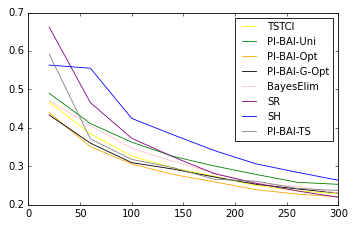

In [19]:
np.random.seed(0)
random.seed(0)

sigma = 1 # observation noise
num_runs = 10000 # number of experiments

algs = [
  ("TSTCI", "yellow", "-", "TSTCI"), 
  ("PI_BAI_Uni", "green", "-", "PI-BAI-Uni"),
  ("PI_BAI_Opt", "orange", "-", "PI-BAI-Opt"),
  ("PI_BAI_G_Opt", "black", "-", "PI-BAI-G-Opt"),
  ("BayesElim", "pink", "-", "BayesElim"),
  ("SR", "purple", "-", "SR"),
  ("SH", "blue", "-", "SH"),
  ("PI_BAI_TS", "gray", "-", "PI-BAI-TS"), 
]

exps = [
  {"K":10}
]

budgets_ = np.arange(20, 340, 40)

for exp in exps:
    
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val
  results_ = defaultdict(list) 

  mu_0 = np.random.uniform(size=(K,)) #np.linspace(0, +1, K)
  sigma_0 = np.linspace(0.1, 0.5, K)

  v, v_0 = sigma**2, sigma_0**2

  for n in budgets_:
      
      w_opt = compute_w_opt(K, mu_0, v_0, v, n, alpha=0.5, num_MC=500)
      w_optimal_design = compute_w_optimal_design(v_0, v, K, n)
      print(np.round(w_optimal_design, 2))

      print('Running experiments with n =', n)
      n_w = K  # warm-up rounds for TS
            
      # bandit environments
      envs = []
      for run in range(num_runs):
        # generate arm means 
        theta = np.random.multivariate_normal(mu_0, np.diag(sigma_0**2))

        # initialize bandit environment
        env = BanditEnvironment(K, theta, sigma)

        # pass parameters for algorithm initialization (not used in simulation)
        env.w_opt = w_opt
        env.w_optimal_design = w_optimal_design
        env.mu_0 = np.copy(mu_0)
        env.sigma_0 = np.copy(sigma_0)

        envs.append(env)
        env.n_w = n_w
        envs.append(env)

      # simulation
      for alg in algs:
        # all runs for a single algorithm
        alg_class = globals()[alg[0]]
        error_prob, error_indicators = evaluate(alg_class, envs, n)
        #for env in envs:
        #    error_prob = evaluate_one(alg_class, env, n)
        results_[alg[3]].append(error_indicators)

np.save('results/MAB/random_setting_K={}.npy'.format(K), results_)     
for alg in algs:
    plt.plot(budgets_, np.mean(results_[alg[3]], axis=1), label=alg[3], color=alg[1])
plt.legend()    